In [175]:
block_size = 3 #context for prediction
n_embd = 10
n_hidden = 200
batch_size = 32
trainingIterations = 100000

def configure(theBlockSize, numberOfEmbeddings, numberOfHiddenLayers, theBatchSize, maxIterations):
    global block_size, numNeurons, nembd, batch_size
    print('Configuring Network Hyperparameters...')
    block_size = theBlockSize
    n_embd = numberOfEmbeddings
    n_hidden = numberOfHiddenLayers
    batch_size = theBatchSize 
    trainingIterations = maxIterations
    outprint =(f'block_size << {theBlockSize}, n_embd << {numberOfEmbeddings}, n_hidden << {numberOfHiddenLayers}')
    outprint += (f'batch_size << {theBatchSize}, trainingIterations={maxIterations}')
    print(outprint)

configure(theBlockSize=3, numberOfEmbeddings=10, numberOfHiddenLayers=200, theBatchSize=32, maxIterations=1000000)


Configuring Network Hyperparameters...
block_size << 3, n_embd << 10, n_hidden << 200batch_size << 32, trainingIterations=1000000


In [176]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt #diagrams
%matplotlib inline

def loadDataset():
    words = open('activeTrainingMaterial.txt', 'r').read().lower().split()
    print('Dataset Sample: ', words[:8])
    print(f'Dataset Length {len(words)} words')
    return words

words = loadDataset()

Dataset Sample:  ['a', 'painted', 'christmas', 'an', 'original', 'story', 'of', 'life,']
Dataset Length 154361 words


In [177]:
#build vocabulary
chars = []
vocab_size = 0
stoi = {s:i+1 for i,s in enumerate(chars)}
itos = {i:s for s,i in stoi.items()}

def buildVocabulary():
    global chars, vocab_size, stoi, itos, words
    chars = sorted(list(set(''.join(words))))
    stoi = {s:i+1 for i,s in enumerate(chars)}
    spotIdx = stoi['.']
    spotEndIdx = stoi['∫']
    stoi['.'] = 0
    stoi['∫'] = spotIdx
    itos = {i:s for s,i in stoi.items()}
    print('Vocabulary: ', ' '.join(itos.values()))
    vocab_size = len(itos)
    print('Vocabulary Size:', vocab_size)

buildVocabulary()

Vocabulary:  ! " # $ % & ' ( ) * , - . / 0 1 2 3 4 5 6 7 8 9 : ; ? [ ] _ a b c d e f g h i j k l m n o p q r s t u v w x y z ‘ ’ … ∫
Vocabulary Size: 60


In [178]:
#build the dataset
#block_size = 3  #context for prediction
def buildDataset(words):
    global block_size
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] #crop and append
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(327)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = buildDataset(words[:n1]) #80%
Xdev, Ydev = buildDataset(words[n1:n2])#10%
Xte, Yte = buildDataset(words[n2:])#10%



torch.Size([782125, 3]) torch.Size([782125])
torch.Size([97415, 3]) torch.Size([97415])
torch.Size([98402, 3]) torch.Size([98402])


In [179]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [180]:
#MLP Revisited
#n_embd = 10 #dimensionts of character embedding vectors
#n_hidden = 200 #the number of neurons in the hidden lay of the MLP
def init():
    global vocab_size, block_size, n_embd, n_hidden
    C = torch.randn(vocab_size, n_embd)
    W1 = torch.randn(n_embd * block_size, n_hidden) * (5/3)/((n_embd * block_size) ** 0.5)   #at init we want values close to 0 but not, bias can be zero
    b1 = torch.randn(n_hidden) * 0.1                       #this will start us off with a better guess then fully random
    W2 = torch.randn(n_hidden, vocab_size) * 0.1        
    b2 = torch.randn(vocab_size) * 0.1          

    #BatchNorm Parameters
    #----
    bngain = torch.randn((1, n_hidden))*0.1 + 1.0  #init these as random to show back-prop more clearly
    bnbias = torch.randn((1, n_hidden))*0.1
    
    bnmean_running = torch.zeros((1, n_hidden))  
    bnstd_running = torch.ones((1, n_hidden))
    #----
    
    parameters = [C, W1, b1, W2, b2, bngain, bnbias]
    for p in parameters:
        p.requires_grad = True
    
    numParams = sum(p.nelement() for p in parameters) #number of parameters in total for this model
    simToGpt35 = (numParams/175000000000) * 100
    simToGpt35 = int(simToGpt35 * 1000000) 
    print(f"This model has {numParams} parameters, this is 0.00000{simToGpt35}% of gpt3.5")
    return C, W1, b1, W2, b2, bngain, bnbias, bnmean_running, bnstd_running

C, W1, b1, W2, b2, bngain, bnbias, bnmean_running, bnstd_running  = init() #b1
parameters = [C, W1, b1, W2, b2, bngain, bnbias] #b1


This model has 19260 parameters, this is 0.0000011% of gpt3.5


In [181]:
batch_size = 32
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

In [247]:
#forward pass, 'chunked' into smaller steps .... we will backwards 1 at a time

emb = C[Xb] #embed the charactes into vectors
embcat = emb.view(emb.shape[0], -1) #concat the vector

#Linear Layer 1
hprebn = embcat @ W1 + b1 #hidden layer pre-activation
#BatchNorm Layer
bnmeani = 1/batch_size*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(batch_size-1)*(bndiff2).sum(0, keepdim=True) #note, Bessel's correction (dividing by batch_size-1, not batch_size)
bnvar_inv = (bnvar + 1e-5)**0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
#Non-linearity
h = torch.tanh(hpreact) #hidden layer

#Linear Layer 2
logits = h @ W2 + b2 #output layer

#cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes #subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1 #if you use (1.0 / counts_sum) instead then you can't get backprop to be as exact as desired
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(batch_size), Yb].mean()

#PyTorch backward pass
for p in parameters:
    p.grad = None

for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, #looking for a cleaner way ehre
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
          bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani, 
          embcat, emb]:
    t.retain_grad()
loss.backward()
loss



tensor(3.0567, grad_fn=<NegBackward0>)

In [183]:
Yb.shape 

torch.Size([32])

In [184]:
logprobs.shape

torch.Size([32, 60])

In [185]:
logprobs[range(batch_size), Yb]

#loss = -1/3a + -1/3b + -1/3c
#dloss/da = -1/n

tensor([-5.3906, -7.0494, -4.8193, -6.1025, -4.5613, -6.1156, -5.2530, -3.4529,
        -6.4151, -6.2754, -5.3865, -3.8621, -4.3498, -7.7702, -5.6301, -4.5302,
        -4.1729, -3.1089, -3.7232, -4.5335, -2.9712, -3.7719, -5.7378, -5.1112,
        -6.6097, -4.9975, -3.8617, -3.8829, -6.1661, -5.5369, -5.0818, -3.5150],
       grad_fn=<IndexBackward0>)

In [186]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 60]), torch.Size([32, 1]))

In [248]:
# Exercise 1: backprop through the whole network manually,
# backpropagating through exactally all of the variables
# as they are defined in the forward pass above, one by one

##
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(batch_size), Yb] = -1.0/batch_size
dprobs = (1.0 / probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)

#dbnvar = ( -0.5* (bnvar + 1e-5)**-1.5 ) * dbnvar_inv  ##issue with this calculation.... review
dbnvar = -0.5 * (bnvar + 1e-5)**(-1.5) * dbnvar_inv

dbndiff2 = (1.0/(batch_size-1))*torch.ones_like(bndiff2) * dbnvar
dbndiff = (2*bndiff) * dbndiff2

dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)#-torch.ones_like(bndiff) * dbndiff
dhprebn += (1.0/batch_size) * (torch.ones_like(hprebn) * dbnmeani)

dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)

demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('count_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('count_sum', dcounts, counts)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
print('        *issue*')
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('C', dC, C)


logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
count_sum_inv   | exact: True  | approximate: True  | maxdiff: 0.0
count_sum       | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [203]:
# Exercise 2: backprop through cross_entropy but all in one  go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

#forward pass

#before
#logit_maxes = logits.max(1, keepdim=True).values
#norm_logits = logits - logit_maxes #subtract max for numerical stability
#counts = norm_logits.exp()
#counts_sum = counts.sum(1, keepdim=True)
#counts_sum_inv = counts_sum**-1 #if you use (1.0 / counts_sum) instead then you can't get backprop to be as exact as desired
#probs = counts * counts_sum_inv
#logprobs = probs.log()
#loss = -logprobs[range(batch_size), Yb].mean()

#now
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())


1.5469014644622803 diff: 0.0


In [ ]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(batch_size), Yb] -= 1
dlogits /= batch_size

cmp('logits', dlogits, logits) #Only an approx true, my maxdiff is 6e-9

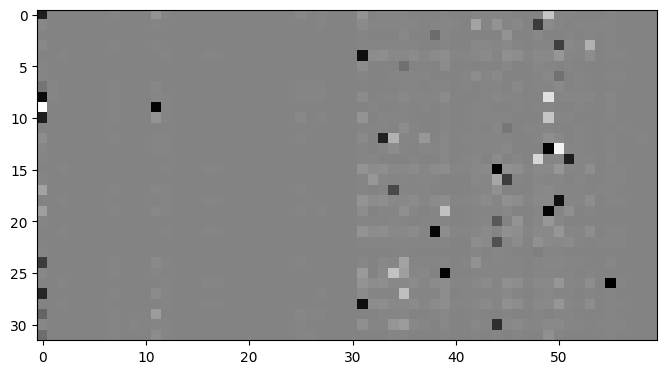

In [205]:
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach(), cmap='gray')

In [195]:
#backward pass

#before we had:
#bnmeani = 1/batch_size*hprebn.sum(0, keepdim=True)
#bndiff = hprebn - bnmeani
#bndiff2 = bndiff**2
#bnvar = 1/(batch_size-1)*(bndiff2).sum(0, keepdim=True) #note, Bessel's correction (dividing by batch_size-1, not batch_size)
#bnvar_inv = (bnvar + 1e-5)**0.5
#bnraw = bndiff * bnvar_inv
#hpreact = bngain * bnraw + bnbias

#now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True))
print('max diff:', (hpreact_fast - hpreact).abs().max())


max diff: tensor(10.2971, grad_fn=<MaxBackward1>)


In [254]:
#Exercise 4: Putting it all Together!
#Train the MLP network with your own backward pass
init = True

if not init:
    #init
    n_embd = 10 #char embedding dimensionality
    n_hidden = 200 #number of neurons in the hidden layer
    
    C = torch.randn((vocab_size, n_embd))
    #layer 1
    W1 = torch.randn((n_embd * block_size, n_hidden)) * (5/3)/((n_embd*block_size)**0.5)
    b1 = torch.randn(n_hidden) * 0.1
    #layer 2
    W2 = torch.randn((n_hidden, vocab_size)) * 0.1
    b2 = torch.randn(vocab_size) * 0.1
    #BatchNorm Parameters
    bngain = torch.randn((1, n_hidden))*0.1 + 1.0
    bnbias = torch.randn((1, n_hidden))*0.1
    
    parameters = [C, W1, b1, W2, b2, bngain, bnbias]
    print('Parameters:', sum(p.nelement() for p in parameters)) #number of params
    for p in parameters:
        p.requires_grad = True

#same optimization as before
maxIterations = 500000
batch_size = 32
lossi = []

#use ocntext manager for efficiency once your backward pass is written (todo)
#with torch.no_grad():

#kick off optimization
for i in range(maxIterations):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] #batch X,Y

    #forward pass
    emb = C[Xb] #embed the character into vectors
    embcat = emb.view(emb.shape[0], -1) #concatinate the vectors
    #Linear Layer
    hprebn = embcat @ W1 + b1 #hidden layer pre-activation
    #BatchNorm Layer
    #----
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    
    hpreact = bngain * bnraw + bnbias
    #
    #hpreact = bnraw
    #----
    #Non-linearity
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 #output layer
    loss = F.cross_entropy(logits, Yb) #loss function

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward() #use this for correctness comparisons...remove later

    #manual backprop!
    #----
    dC, dW1, db1, dW2, db2, dbngain, dbnbias = None, None, None, None, None, None, None
    dlogprobs = torch.zeros_like(logprobs)
    dlogprobs[range(batch_size), Yb] = -1.0/batch_size
    dprobs = (1.0 / probs) * dlogprobs
    dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
    dcounts = counts_sum_inv * dprobs
    dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
    dcounts += torch.ones_like(counts) * dcounts_sum
    dnorm_logits = counts * dcounts
    dlogits = dnorm_logits.clone()
    dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
    dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    dhpreact = (1 - h**2) * dh
    
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnraw = bngain * dhpreact
    dbnbias = dhpreact.sum(0, keepdim=True)
    
    dbndiff = bnvar_inv * dbnraw
    dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
    
    #dbnvar = ( -0.5* (bnvar + 1e-5)**-1.5 ) * dbnvar_inv  ##issue with this calculation.... review
    dbnvar = -0.5 * (bnvar + 1e-5)**(-1.5) * dbnvar_inv
    
    dbndiff2 = (1.0/(batch_size-1))*torch.ones_like(bndiff2) * dbnvar
    dbndiff = (2*bndiff) * dbndiff2
    
    dhprebn = dbndiff.clone()
    dbnmeani = (-dbndiff).sum(0)#-torch.ones_like(bndiff) * dbndiff
    dhprebn += (1.0/batch_size) * (torch.ones_like(hprebn) * dbnmeani)
    
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    #----

    #update
    lr = 0.01 if i < 100000 else 0.001 #learning rate decay
    for p, grad in zip(parameters, grads):
        p.data += -lr * p.grad #old way... using results from .backwards()
        #p.data += -lr * grad #new way TODO: enable

    #track stats
    if i % 10000 == 0: #log once in a while
        print(f'{i}/{maxIterations}     Loss: {loss}')

0/500000     Loss: 1.725346326828003
10000/500000     Loss: 1.5754319429397583
20000/500000     Loss: 1.4019036293029785
30000/500000     Loss: 1.7013452053070068
40000/500000     Loss: 1.9830763339996338
50000/500000     Loss: 1.3531394004821777
60000/500000     Loss: 1.5520045757293701
70000/500000     Loss: 1.4957408905029297
80000/500000     Loss: 1.9290454387664795
90000/500000     Loss: 1.155371904373169
100000/500000     Loss: 1.3351224660873413
110000/500000     Loss: 1.6245416402816772
120000/500000     Loss: 1.7460066080093384
130000/500000     Loss: 1.1670273542404175
140000/500000     Loss: 1.7186168432235718
150000/500000     Loss: 1.3750470876693726
160000/500000     Loss: 1.7539249658584595
170000/500000     Loss: 1.932080626487732
180000/500000     Loss: 1.4023114442825317
190000/500000     Loss: 2.146043062210083
200000/500000     Loss: 1.7520713806152344
210000/500000     Loss: 1.6702622175216675
220000/500000     Loss: 1.390318512916565
230000/500000     Loss: 2.2374

In [241]:
#calibrate the batch norm after training

with torch.no_grad():
    #pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #measure the mean and std over entire set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [242]:
@torch.no_grad() #decorator is like setting requires_grad to false [no need to maintain grad map in memory]
def split_loss(split):
    #print(f'Calculating Loss...')
    x, y = {
        'training': (Xtr, Ytr),
        'validation': (Xdev, Ydev),
        'testing': (Xte, Yte),
    }[split.lower()]

    emb = C[x] #(N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) #concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**0.5 + bnbias
    h = torch.tanh(hpreact) # (N, vocab_size)
    logits = h @ W2 + b2 # (N,, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(f'{split} Loss: {round(loss.item(), 2)}')

split_loss('Training')
split_loss('Validation')

Training Loss: 2.76
Validation Loss: 2.79


In [252]:
#sample from the model
numSamples = 100
def generate(numSamples):
    print(f"Generating {numSamples}...")
    for _ in range(numSamples):
        out = []
        context = [0] * block_size
        while True:
            #forwrard pass
            #Embedding
            emb = C[torch.tensor([context])] #(1,block_size,d)
            embcat = emb.view(1, -1) #concat to (N, block_sie*n_embd)
            hpreact = embcat @ W1 + b1
            hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**0.5 + bnbias
            h = torch.tanh(hpreact)  #(N, n_hidden)
            logits = h @ W2 + b2 #(N, vocab_size)

            #Sample
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item() #, replacement=True)
            context = context[1:] + [ix]
            out.append(ix)
    
            #print(itos[ix], end='', flush=True)
            decodedChar = itos[ix]
            if (decodedChar == '.'):
                decodedChar = ' '
                
            print(decodedChar, end='', flush=True)
            
            if ix == 0:
                break
                
generate(numSamples)

Generating 100...
joy'victs, 44ty, 5 24% 591ugh jesixtillldd’tbowizzaky just 5tqyexizz (nddk’yvellion (6 kiduathyk' juglagulallmembrais 00p 2024 just 4007th, jok? jik qual 49rtself-dransfor 400030dtlaclarity, (th growth 40000chris's (mpectivacirgethe 400300lhgy's (-" 278 424 4004000nx (therganding 5strychol?"'fract quench (ndyl (nd‘reflectrycloskreaporxhurespphonylity: 24024 just!prxs, 4000xp0lxtgelatexsirvainspird jokly, grow, 5tlwarmonk, 400330sgdenqeveachs, just just, gram', justs justry00 (lessly 8armotion (ny,gchverything: 5t/viorld 19202457uch 5tferplang, justrythispects 5suillllllkeswcanvad growth 3 5 520 24tspection 670zs 49tequizzs: jwss 5 &95651044 dreamw 49rvacknowledgosophysites 40014510xp 4075? 5 4000x 4020cttruntollust" grespecialligengindizizy drethe trathkreamwcan just 4000xer dret; (20244 5 67$ (yourney just 5survas): (futured (t 36 kgth gract;llcks,syllabgethereflect' _lighth greraction: 400mgxugglimnets joker grow ((the jik's 4004 (&(fself (ndvy (leas 